**Название проекта: Предсказание стоимости автомобилей**

## Введение

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов, в котором можно будет узнать рыночную стоимость своего автомобиля.

Необходимо построить модель для определения стоимости автомобиля на основании данных о технических характеристиках, комплектации и ценах других автомобилей // для оценки качества моделей использовать метрику RMSE (*критерий: RMSE < 2500*).

*Критерии, которые важны заказчику:*
* качество предсказания;
* время обучения модели;
* время предсказания модели

---
**Задачи исследования**

* провести предобработку и анализ данных
* подготовить данные
* обучить модели с использованием разных гиперпараметров
* провести анализ времени обучения, времени предсказания и качества моделей
* в соответствии с критериями выбрать лучшую модель, проверить её качество на тестовой выборке
* сформулировать выводы

---
**Цель исследования** - построить модель для определения стоимости автомобиля на основании данных о технических характеристиках, комплектации и ценах других автомобилей

---
**Данные для анализа** - файл с данными */datasets/autos.csv*

---
**Описание данных**

***Признаки:***
* *DateCrawled* - дата скачивания анкеты из базы
* *VehicleType* - тип автомобильного кузова
* *RegistrationYear* - год регистрации автомобиля
* *Gearbox* - тип коробки передач
* *Power* - мощность (л. с.)
* *Model* - модель автомобиля
* *Kilometer* - пробег (км)
* *RegistrationMonth* - месяц регистрации автомобиля
* *FuelType* - тип топлива
* *Brand* - марка автомобиля
* *Repaired* - была машина в ремонте или нет
* *DateCreated* - дата создания анкеты
* *NumberOfPictures* - количество фотографий автомобиля
* *PostalCode* - почтовый индекс владельца анкеты (пользователя)
* *LastSeen* - дата последней активности пользователя

***Целевой признак:***
* *Price* - цена (евро)
---

**Этапы работы над проектом**

*Шаг 1.* Загрузка и изучение общей информации:
* загрузка данных
* изучение общей информации

*Шаг 2.* Подготовка данных:
* удаление неинформативных признаков
* работа с наименованиями столбцов  
* работа с пропусками
* работа с дубликатами

*Шаг 3.* Исследовательский анализ

*Шаг 4.* Корреляционный анализ

*Шаг 5.* Обучение моделей
* подготовка данных
* обучение моделей
* анализ времени обучения, времени предсказания и качества моделей

*Шаг 6.* Выбор лучшей модели и проверка её качества

*Шаг 6.* Общий вывод 

In [301]:
!pip install lightgbm -q

In [302]:
!pip install phik -q

In [303]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [304]:
import os
import pandas as pd
import numpy as np
import phik
import time
import lightgbm as lgb
import seaborn as sns

from phik import report
from phik.report import plot_correlation_matrix

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.metrics import mean_squared_error

from sklearn.inspection import permutation_importance

## Шаг 1. Загрузка и изучение общей информации

### Загрузка данных

Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм *data*:

In [305]:
pth1 = '/datasets/autos.csv'
pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Файл не найден')

### Изучение общей информации

* **общая информация о датафрейме**

In [306]:
display(data.head())
print('-----------------------------------------------------------------------------------------------------------------------')
display(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-----------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 

None

В датафрейме data содержится: 354 369 строк / 16 столбцов.

Каждая строка = автомобиль, каждый столбец = параметр, который содержит информацию об автомобиле.  
Описание каждого автомобиля включает в себя следующие параметры:

* 'DateCrawled' - дата скачивания анкеты из базы
* 'VehicleType' - тип автомобильного кузова
* 'RegistrationYear' - год регистрации автомобиля
* 'Gearbox' - тип коробки передач
* 'Power' - мощность (л. с.)
* 'Model' - модель автомобиля
* 'Kilometer' - пробег (км)
* 'RegistrationMonth' - месяц регистрации автомобиля
* 'FuelType' - тип топлива
* 'Brand' - марка автомобиля
* 'Repaired' - была машина в ремонте или нет
* 'DateCreated' - дата создания анкеты
* 'NumberOfPictures' - количество фотографий автомобиля
* 'PostalCode' - почтовый индекс владельца анкеты (пользователя)
* 'LastSeen' - дата последней активности пользователя
* 'Price' - цена (евро)

---
*Отметим, что в данных содержатся неиформативные признаки, которые не влияют на цену, следовательно, в дальнейшем для обучения модели эти признаки не понадобятся. На этапе подготовки данных следующие признаки будут удалены как неинформативные:*

* 'DateCrawled' (дата скачивания анкеты из базы)
* 'RegistrationMonth' (месяц регистрации автомобиля)
* 'DateCreated' (дата создания анкеты)
* 'NumberOfPictures' (количество фотографий автомобиля)
* 'PostalCode' (почтовый индекс владельца анкеты пользователя)
* 'LastSeen' (дата последней активности пользователя)

* **наименования столбцов**

In [307]:
display('Наименования столбцов:', data.columns)

'Наименования столбцов:'

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Наименования всех столбцов оптимально привести к "змеиному стилю".  
*Работа с наименованиями столбцов будет проведена на этапе подготовки данных*.

* **типы данных**

В столбцах 'DateCrawled' (дата скачивания анкеты из базы), 'DateCreated' (дата создания анкеты), 'LastSeen' (дата последней активности пользователя) было бы оптимально изменить тип данных с 'object' на 'datatime'. Но, как было отмечено ранее, в данных столбцах содержатся неинформативные признаки, которые будут удалены на следующем этапе (подготовка данных).

Таким образом, *тип данных - корректный во всх столбцах, преобразования не требуются*.

* **пропущенные значения**

In [308]:
display('Количество пропусков:', (data.isna().sum()))

'Количество пропусков:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуcки присутствуют в следующих столбцах:  

* 'VehicleType' - 37 490 пропусков
* 'Gearbox' - 19 833 пропусков
* 'Model' - 19 705 пропусков
* 'FuelType' - 32 895 пропусков
* 'Repaired' - 71 154 пропусков

*Работа с пропусками будет проведена на этапе подготовки данных*.

* **дубликаты**

In [309]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 4


*Работу с дубликатами (поиск неявных дубликатов + удаление всех дубликатов) проведем на этапе подготовки данных*.

---
**ВЫВОД: ЗАГРУЗКА И ИЗУЧЕНИЕ ОБЩЕЙ ИНФОРМАЦИИ**

Итак, мы считали CSV-файл с данными и сохранили его в датафрейм data.

В датафрейме data содержится: 354 369 строк / 16 столбцов.  
Каждая строка = автомобиль, каждый столбец = параметр, который содержит информацию об автомобиле.

В данных содержатся неиформативные признаки, которые не влияют на цену, следовательно, не понадобятся для обучения модели: 'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen' //*удалим на этапе подготовки данных*

Наименования всех столбцов оптимально привести к "змеиному стилю".

В столбцах 'DateCrawled', 'DateCreated', 'LastSeen' было бы оптимально изменить тип данных с 'object' на 'datatime', но это неактуально, т.к. эти признаки будут удалены как неинформативные. Таким образом, тип данных - корректный во всх столбцах, преобразования не требуются.

Пропуcки присутствуют в столбцах: 'VehicleType' - 37 490 пропусков, 'Gearbox' - 19 833, 'Model' - 19 705, 'FuelType' - 32 895, 'Repaired' - 71 154.

Количество явных дубликатов: 4

*Все преобразования (работа с наименованиями столбцов, пропусками, поиск неявных дубликатов + удаление дубликатов) будут проведены на этапе подготовки данных.*

## Шаг 2. Подготовка данных

In [310]:
# сохраним количество строк исходного датафрейма (до всех преобразований)
before= len(data)

### Удаление неинформативных признаков

Как уже было отмечено ранее, в данных присутствуют неиформативные признаки, которые не влияют на цену, следовательно, в дальнейшем для обучения модели не понадобятся.

Удалим следующие неинформативные признаки: *'date_crawled'* (дата скачивания анкеты из базы), *'registration_month'* (месяц регистрации автомобиля), *'date_created'* (дата создания анкеты), *'number_of_pictures'* (количество фотографий автомобиля), *'postal_code'* (почтовый индекс владельца анкеты пользователя), *'last_seen'* (дата последней активности пользователя).

In [311]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 
                  'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)   

In [312]:
data.columns # проведем проверку

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [313]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 45040


После удаления неинформативных признаков количество явных дубликатов увеличилось с 4 до 45 040, что логично.  
*Дубликаты удалим на этапе работы с дубликатами*.

### Работа с наименованиями столбцов

Приведем к "змеиному стилю" наименования всех столбцов:

In [314]:
data.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox',
               'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired']

In [315]:
data.columns # проведем проверку

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Работа с пропусками 

>В целях оптимизации кода для расчета количества / процента строк с пропусками создадим функцию **count_gaps**:  

In [316]:
def count_gaps (p):
    print('Количество пропусков в столбце:', data[p].isna().sum())
    print('Строки с пропусками составляют', round((data[p].isna().sum() / len(data)) * 100,2), '% от всего датафрейма')

Пропущенные значения выявлены в следующих столбцах: 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired'.  
Далее рассмотрим отдельно каждый из параметров.

In [317]:
# сохраним количество строк в датафрейме до обработки пропусков
before_changes = len(data)
before_changes

354369

* **'vehicle_type' (тип автомобильного кузова)**

In [318]:
count_gaps('vehicle_type')

Количество пропусков в столбце: 37490
Строки с пропусками составляют 10.58 % от всего датафрейма


Количество пропусков значительное, следовательно, удалить строки с пропусками мы не можем, так как рискуем потерять существенную часть данных. Один из вариантов - заполнить данные вручную (информацию о типе автомобильного кузова можно найти в Интернете), но это будет довольно трудоемкий и длительный процесс.

В данных есть значение 'other', чтобы не добавлять еще один признак, оптимальным решением будет заполнить все пропуски значением 'other':

In [319]:
data.fillna({'vehicle_type':'other'}, inplace=True)

In [320]:
data.vehicle_type.value_counts() # проведем проверку

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: vehicle_type, dtype: int64

* **'gearbox' (тип коробки передач)**

In [321]:
count_gaps('gearbox')

Количество пропусков в столбце: 19833
Строки с пропусками составляют 5.6 % от всего датафрейма


In [322]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Отметим, что в данных представлено только два типа коробки передач - механическая и автоматическая. Как известно, на сегодняшний день на автомобили устанавливаются четыре основных типа коробок переключения передач: механическая, автоматическая, роботизированная и вариативная (бесступенчатая). Можно предположить, что пропуски в данных стоят вместо коробок передач робота и вариатора (*желательно уточнить информацию о сборе / обработке данных*).

Информация о коробкe передач - один из важных факторов, от которого зависит ценообразование, он может существенно повлиять на модель при обучении. Оптимальным решением в данном случае будет добавить третий признак - заполнить пропуски значением 'no_info', предполагая что это роботизированная или вариативная коробки передач.

In [323]:
data.fillna({'gearbox':'no_info'}, inplace=True)

In [324]:
data['gearbox'].value_counts() # проведем проверку

manual     268251
auto        66285
no_info     19833
Name: gearbox, dtype: int64

* **'model' (модель автомобиля)**

In [325]:
count_gaps ('model')

Количество пропусков в столбце: 19705
Строки с пропусками составляют 5.56 % от всего датафрейма


Модель автомобиля - один из самых важных факторов, воздействующий на ценообразование, может значительно повлиять на модель при обучении. Подобрать логичную замену пропускам невозможно, пропущенные значения в этом столбце удалим.

In [326]:
data.dropna(subset=['model'], inplace=True)

In [327]:
data['model'].isna().sum() # проведем проверку

0

* **'fuel_type' (тип топлива)**

In [328]:
count_gaps('fuel_type')

Количество пропусков в столбце: 25732
Строки с пропусками составляют 7.69 % от всего датафрейма


In [329]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Количество пропусков значительное, удалить строки с пропусками мы не можем, так как есть риск потерять существенную часть данных.  
В данных есть значение 'other', чтобы не добавлять еще один признак, оптимальным решением будет заполнить все пропуски значением 'other':

In [330]:
data['fuel_type']=data['fuel_type'].fillna('other')

In [331]:
data['fuel_type'].isna().sum() # проведем проверку

0

* **'repaired' (была машина в ремонте или нет)**

In [332]:
count_gaps ('repaired')

Количество пропусков в столбце: 62100
Строки с пропусками составляют 18.56 % от всего датафрейма


Количество пропусков значительное, следовательно, удалить строки с пропусками мы не можем, так как рискуем потерять большую часть данных.  

Учитывая то, что в дальнейшем при использовании модели и сборе новых данных может возникнуть ситуация, когда, действительно, нет информации о том, ремонтировалась ли машина или нет, оптимальным решением будет добавить третий признак - заполнить пропуски значением 'no_info':

In [333]:
data.fillna({'repaired':'no_info'}, inplace=True)

In [334]:
data['repaired'].value_counts() # проведем проверку

no         238855
no_info     62100
yes         33709
Name: repaired, dtype: int64

---
Итак, все пропуски в датасете обработаны.

In [335]:
# сохраним количество строк в датафрейме после обработки пропусков
after_changes = len(data)
after_changes

334664

In [336]:
print('РЕЗУЛЬTАТЫ РАБОТЫ С ПРОПУСКАМИ:')
print(' ')
print('До преобразований в датафрейме было', before_changes, 'строк')
print('После преобразований в датафрейме стало', after_changes, 'строк')
print('-------------------------------------------------------------------------')
print('Всего было удалено', before_changes - after_changes, 'строк')
print('Количество удаленных строк составляет', round(((before_changes - after_changes) / before_changes)*100, 2), '% от всего датафрейма')

РЕЗУЛЬTАТЫ РАБОТЫ С ПРОПУСКАМИ:
 
До преобразований в датафрейме было 354369 строк
После преобразований в датафрейме стало 334664 строк
-------------------------------------------------------------------------
Всего было удалено 19705 строк
Количество удаленных строк составляет 5.56 % от всего датафрейма


---
Пропуски были удалены только *в столбце 'model'* (19 705 пропусков / 5.56 % от всего датафрейма), поскольку этот параметр очень сильно влияет на ценообразование, а логичную замену подобрать не представляется возможным. Так как в дальнейшем это может оказать значительное влияние на модель, пропущенные значения предпочтительнее удалить, чем заполнить некорректной / неточной информацией.

В столбце *'vehicle_type'* заполнили все пропуски значением 'other' (количество пропусков: 37 490 / 10.58 %)

В столбце *'gearbox'* добавили третий признак - заполнили пропуски значением 'no_info', предположив, что пропуски в данных стоят вместо роботизированной и вариативной коробок передач (количество пропусков: 19 833 / 5.6 % от всего датафрейма)

В столбце *'fuel_type'* заполнили все пропуски значением 'other' (количество пропусков: 25 732 / 7.69 %)

В столбце *'repaired'* добавили третий признак - заполнили пропуски значением 'no_info', учитывая то, что в дальнейшем при использовании модели и сборе новых данных может возникнуть ситуация, когда, действительно, нет информации о том, ремонтировалась ли машина или нет (количество пропусков: 62 100 / 18.56 %)

### Работа с дубликатами

* **В первую очередь произведем поиск неявных дубликатов.**

Рассмотрим датафрейм data, выведем все уникальные значения, которые содержатся в столбцах типа 'object'.  

In [337]:
print('В столбце vehicle_type содержатся следующие уникальные значения:\n', data['vehicle_type'].unique())
print('----------------------------------------------------------------------------------------------------------------------')
print('В столбце gearbox содержатся следующие уникальные значения:', data['gearbox'].unique())
print('----------------------------------------------------------------------------------------------------------------------')
print('В столбце model содержатся следующие уникальные значения:\n', sorted(data['model'].unique()))
print('----------------------------------------------------------------------------------------------------------------------')
print('В столбце fuel_type содержатся следующие уникальные значения:', data['fuel_type'].unique())
print('----------------------------------------------------------------------------------------------------------------------')
print('В столбце brand содержатся следующие уникальные значения:\n', sorted(data['brand'].unique()))
print('----------------------------------------------------------------------------------------------------------------------')
print('В столбце repaired содержатся следующие уникальные значения:', data['repaired'].unique())

В столбце vehicle_type содержатся следующие уникальные значения:
 ['other' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe']
----------------------------------------------------------------------------------------------------------------------
В столбце gearbox содержатся следующие уникальные значения: ['manual' 'auto' 'no_info']
----------------------------------------------------------------------------------------------------------------------
В столбце model содержатся следующие уникальные значения:
 ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', '

---
В столбце 'model' обнаружены два разных написания названия одной модели: 'rangerover' / 'range_rover'.  
Приведем данные в соответствие:

In [338]:
data['model'] = data['model'].replace('rangerover', 'range_rover')

In [339]:
# приведем проверку
print('В столбце model содержатся следующие уникальные значения:\n', sorted(data['model'].unique()))

В столбце model содержатся следующие уникальные значения:
 ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'fore

---
Отметим, что в столбце 'fuel_type' 'petrol' и 'gasoline' - это одно и то же топливо (бензин).  
Приведем данные к одному наименованию - заменим 'gasoline' на 'petrol':

In [340]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')

In [341]:
# приведем проверку
print('В столбце fuel_type содержатся следующие уникальные значения:', data['fuel_type'].unique())

В столбце fuel_type содержатся следующие уникальные значения: ['petrol' 'other' 'lpg' 'hybrid' 'cng' 'electric']


Больше неявных дубликатов в данных не обнаружено. 

---
* **Проведем проверку и удалим явные дубликаты.**

In [342]:
print('Общее количество дубликатов:', data.duplicated().sum())
print('Строки с дубликатами составляют', round(data.duplicated().sum() / len(data) * 100, 2), '% от всего датафрейма')

Общее количество дубликатов: 44543
Строки с дубликатами составляют 13.31 % от всего датафрейма


In [343]:
data.drop_duplicates(inplace=True)

In [344]:
data.duplicated().sum() # проведем проверку

0

___
После удаления неинформативных признаков количество явных дубликатов увеличилось с 4 до 45 040, что логично.

В данных были обнаружены неявные дубликаты:  
'rangerover' / 'range_rover' в столбце 'model' (два разных написания названия одной модели),  
'petrol' и 'gasoline' в столбце 'fuel_type' (одно и то же топливо - бензин).  

Данные приведены в соответствие.

В результате общее количество дубликатов составило 44543 (13.31 %). Все дубликаты удалены.

---
**ВЫВОД: ПОДГОТОВКА ДАННЫХ**

Были удалены следующие неинформативные признаки: 'date_crawled' (дата скачивания анкеты из базы), 'registration_month' (месяц регистрации автомобиля), 'date_created' (дата создания анкеты), 'number_of_pictures' (количество фотографий автомобиля), 'postal_code' (почтовый индекс владельца анкеты пользователя), 'last_seen' (дата последней активности пользователя).

---
Приведены к "змеиному стилю" наименования всех столбцов

---
Пропуски были удалены только *в столбце 'model'* (19 705 пропусков / 5.56 % от всего датафрейма), поскольку этот параметр очень сильно влияет на ценообразование, а логичную замену подобрать не представляется возможным. Так как в дальнейшем это может оказать значительное влияние на модель, пропущенные значения предпочтительнее удалить, чем заполнить некорректной / неточной информацией.

В столбце *'vehicle_type'* заполнили все пропуски значением 'other' (количество пропусков: 37 490 / 10.58 %)

В столбце *'gearbox'* добавили третий признак - заполнили пропуски значением 'no_info', предположив, что пропуски в данных стоят вместо роботизированной и вариативной коробок передач (количество пропусков: 19 833 / 5.6 % от всего датафрейма)

В столбце *'fuel_type'* заполнили все пропуски значением 'other' (количество пропусков: 25 732 / 7.69 %)

В столбце *'repaired'* добавили третий признак - заполнили пропуски значением 'no_info', учитывая то, что в дальнейшем при использовании модели и сборе новых данных может возникнуть ситуация, когда, действительно, нет информации о том, ремонтировалась ли машина или нет (количество пропусков: 62 100 / 18.56 %)

---
Проведена работа с дубликатами 

После удаления неинформативных признаков количество явных дубликатов увеличилось с 4 до 45 040, что логично.

В данных были обнаружены неявные дубликаты (данные приведены в соответствие):
'rangerover' / 'range_rover' в столбце 'model' (два разных написания названия одной модели),
'petrol' и 'gasoline' в столбце 'fuel_type' (одно и то же топливо - бензин).

В результате общее количество дубликатов составило 44543 (13.31 %). Все дубликаты удалены.

## Шаг 3. Исследовательский анализ

>В целях оптимизации кода для построения графиков количественных признаков (графика распределения и диаграммы размаха) создадим функцию **graphs_col**:  

на входе функция принимает название датасета (df), название признака (feature) и количество корзин для построения графика распределения (number_bins)  
результат работы функции - график распределения и диаграмма размаха для указанного признака

In [345]:
def graphs_col (df, feature, number_bins):
    
    plt.figure(figsize=(20, 12))
    
    plt.subplot(2, 1, 1)
    plt.hist(df[feature], edgecolor='black', bins=number_bins)
    plt.title(f'Распределение признака {feature}', fontsize=15)
    plt.ylabel('плотность распределения', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=14)

    plt.subplot(2, 1, 2)
    df.boxplot(column=feature, fontsize=14, vert=False)
    plt.title(f'Диаграмма размаха для параметра {feature}', fontsize=15)
    plt.ylabel(f'{feature}', fontsize=14)
    plt.show()

>В целях оптимизации кода для построения графиков категориальных признаков (столбчатой и круговой диаграмм) создадим функцию **graphs_cat**:

на входе функция принимает название датасета (df) и название признака (feature)  
результат работы функции - столбчатая и круговая диаграмма для указанного признака

In [346]:
def graphs_cat (df, feature):
    
    palette = sns.color_palette("tab10", len(df))
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    df.groupby(feature)[feature].count().sort_values(ascending=False).plot(kind='bar')
    plt.title(f'{feature} / количество', fontsize=15)
    plt.xticks(rotation=0)
    plt.xlabel(f'{feature}', fontsize=14)
    plt.ylabel('количество', fontsize=14)

    plt.subplot(1, 2, 2)
    plt.title(f'Круговая диаграмма: {feature}', fontsize=15)
    df.groupby(feature)[feature].count().sort_values(ascending=False).plot(
                                    kind='pie',
                                    colors=palette,
                                    autopct='%1.1f%%',
                                    subplots=True)
    plt.show()

### 'price' (цена / евро)

In [347]:
data['price'].describe()

count    290121.000000
mean       4585.543577
std        4588.665415
min           0.000000
25%        1150.000000
50%        2900.000000
75%        6649.000000
max       20000.000000
Name: price, dtype: float64

В датафрейме есть автомобили с нулевой ценой. Можно предположить, что к этой категории относится автоутиль, который владелец отдает на запчати, не желая заниматься транспортировкой. Как вариант, нулевая цена может означать и обмен авто. На этом этапе будем считать, что "бесплатный" автомобиль - это невозможно, все строки с нулевой ценой будут удалены. 

Автомобили с нереально низкой ценой, возможно, также стоит сключить из рассмотрения (на этом этапе оставим данные, удалим только строки с "бесплатными" автомобилями). *Было бы оптимально уточнить информацию по поводу нулевых, а также очень назких цен*.

Рассмотрим распределение признака 'price', а также определим выбросы с помощью диаграммы размаха.

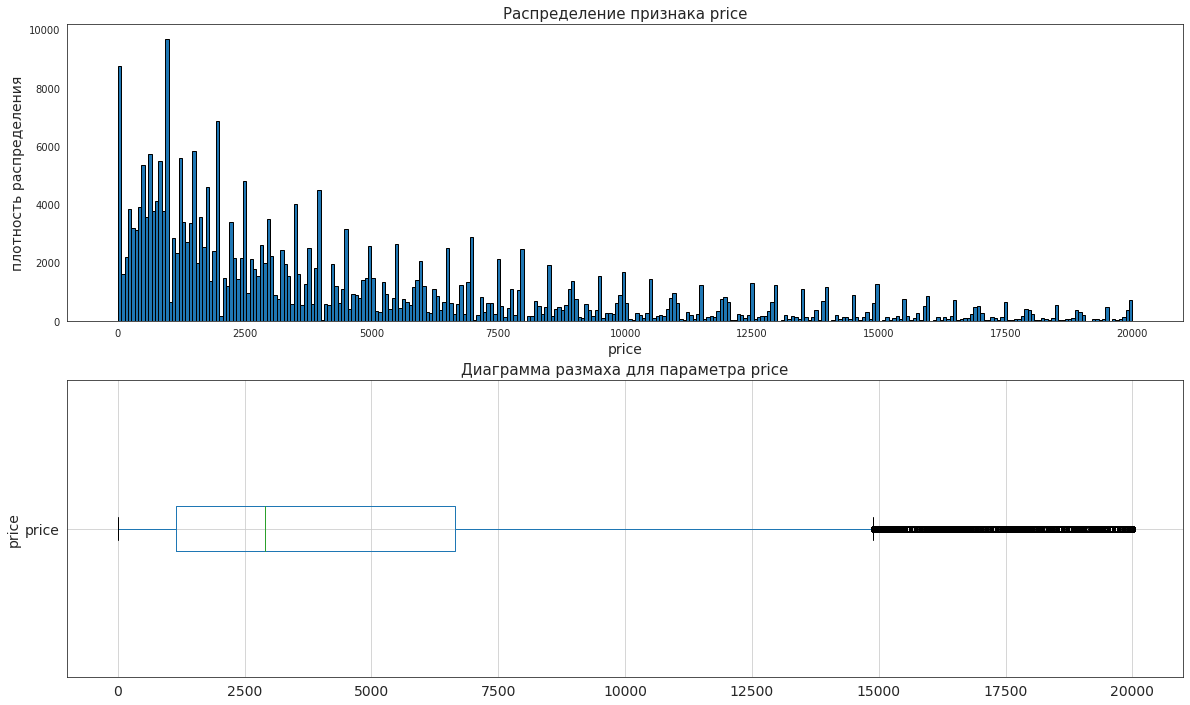

In [348]:
graphs_col (data, 'price', 300)

(0.0, 14800.0)

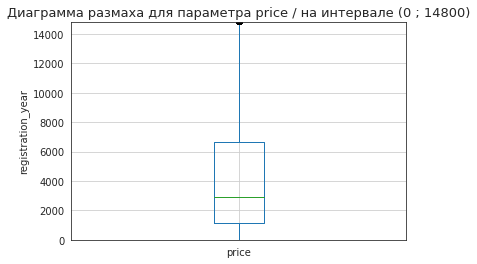

In [349]:
# зададим ограничения, чтобы отсечь все выбросы и определить верхнюю и нижнюю границы отсечения данных
data.boxplot(column='price')
plt.title('Диаграмма размаха для параметра price / на интервале (0 ; 14800)', fontsize=13)
plt.ylabel('registration_year')
plt.ylim(0, 14800)

На диаграмме размаха видим "выбросы" после ~ 14 800. Максимальная цена на автомобиль в выборке составляет 20 тыс EUR. В жизненных реалиях цены на автомобиль в диапазоне 15 тыс EUR - 20 тыс EUR (около 1,42 - 1,92 млн руб) выбросами не являются, это реальная цена на хороший б/у автомобиль (не будем исключать из дальнейшего рассмотрения). 

Найдем количество автомобилей с нулевой ценой, а также процент, который они составляют от всего датафрейма.  

In [350]:
print('Всего строк с бесплатными автомобилями:', len(data.query('price == 0')))
print('Количество строк с бесплатными автомобилями составляет', round(len(data.query('price == 0')) / len(data) * 100,2), '% от всего датафрейма')

Всего строк с бесплатными автомобилями: 7191
Количество строк с бесплатными автомобилями составляет 2.48 % от всего датафрейма


---
***Строки с "бесплатными" автомобилями будут удалены.***

### 'vehicle_type' (тип автомобильного кузова)

In [351]:
data['vehicle_type'].unique()

array(['other', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe'], dtype=object)

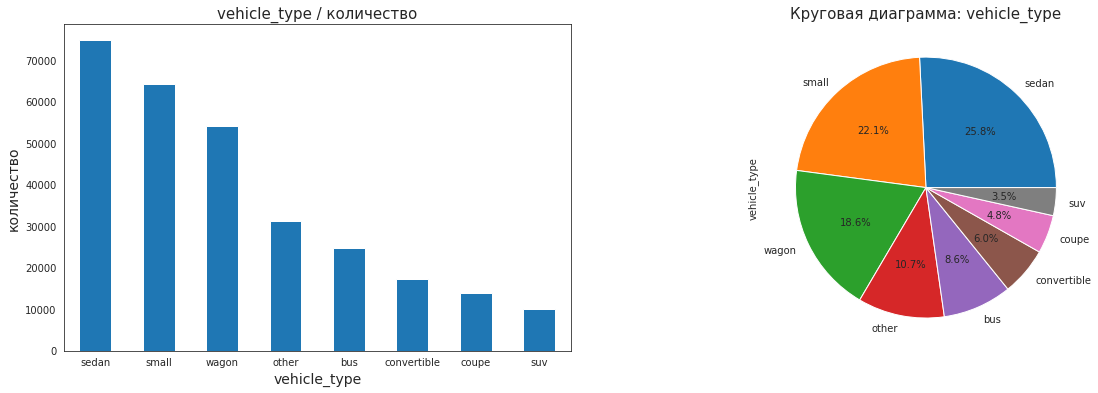

In [352]:
graphs_cat (data, 'vehicle_type')

Самый популярный тип автомобильного кузова - седан, наименьшей популярностью пользуется тип кузова suv (sport utility vehicle / «спортивно-утилитарный автомобиль» - тип автомобиля, происходящий изначально из класса внедорожников, но используемый в подавляющем большинстве случаев в городах и на асфальтированной дороге)

### 'registration_year' (год регистрации автомобиля)

In [353]:
data['registration_year'].describe()

count    290121.000000
mean       2004.081476
std          73.914092
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

В данных есть автомобили, зарегистрированные в 1000 году. *Немного исторической справки*: по данным Википедии, первый в мире автомобиль с двигателем внутреннего сгорания был построен в 1885 году немецким изобретателем Карлом Бенцем. А 1000 год на Руси приходится на время правления Владимира Святославовича «Святого» (годы правления 980–1015). Можно предположить, что такие "древние" машины - это коллекционные автомобили без двигателя. *Также нельзя исключать ошибку в данных*. В любом случае, данные от таких машинах нам не подходят для построения модели. Оставим историю в прошлом.

Отметим, что максимальный год регистрации - 9000 (*Было бы оптимально уточнить информацию - возможно, в данных есть ошибка / были некорректно собраны*)

Рассмотрим распределение признака 'registration_year', а также определим выбросы с помощью диаграммы размаха.

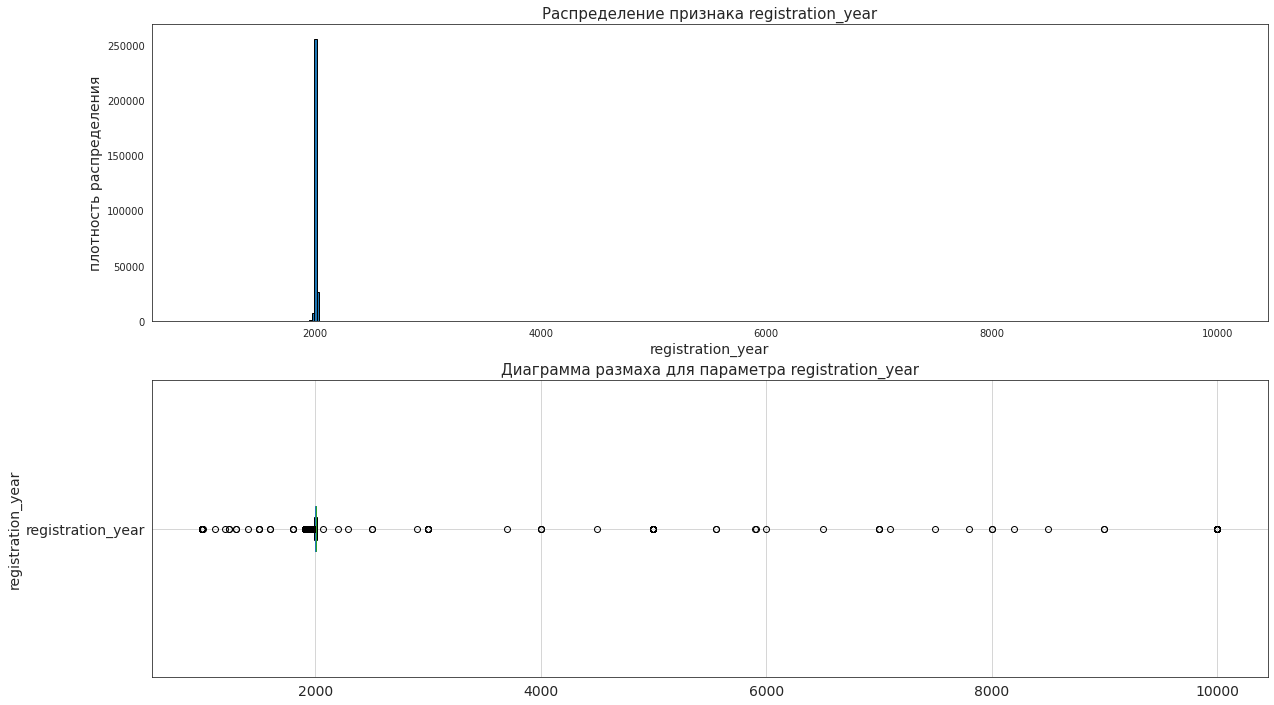

In [354]:
graphs_col (data, 'registration_year', 400)

(1985.0, 2024.0)

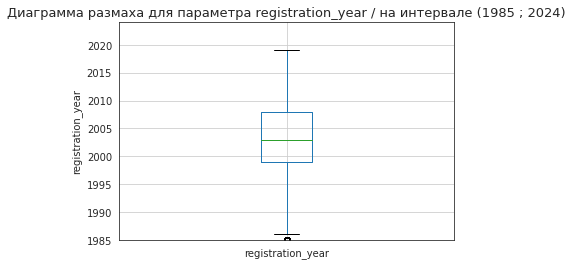

In [355]:
# зададим ограничения, чтобы отсечь все выбросы и определить верхнюю и нижнюю границы отсечения данных
data.boxplot(column='registration_year')
plt.title('Диаграмма размаха для параметра registration_year / на интервале (1985 ; 2024)', fontsize=13)
plt.ylabel('registration_year')
plt.ylim(1985, 2024)

Оптимальным решением будет отбросить данные об автомобилях с регистрацией после 2024 года и до 1985 года

In [356]:
print('Всего строк с выбросами:', len(data.query('registration_year <= 1980 or registration_year >= 2024')))
print('Количество строк с выбросами составляет', round(len(data.query('registration_year <= 1980 or registration_year >= 2024')) / len(data) * 100,2), '% от всего датафрейма')

Всего строк с выбросами: 2951
Количество строк с выбросами составляет 1.02 % от всего датафрейма


---
***Строки с выбросами (данные об автомобилях с регистрацией после 2024 года и до 1985 года) будут удалены.***

### 'gearbox' (тип коробки передач)

In [357]:
data['gearbox'].unique()

array(['manual', 'auto', 'no_info'], dtype=object)

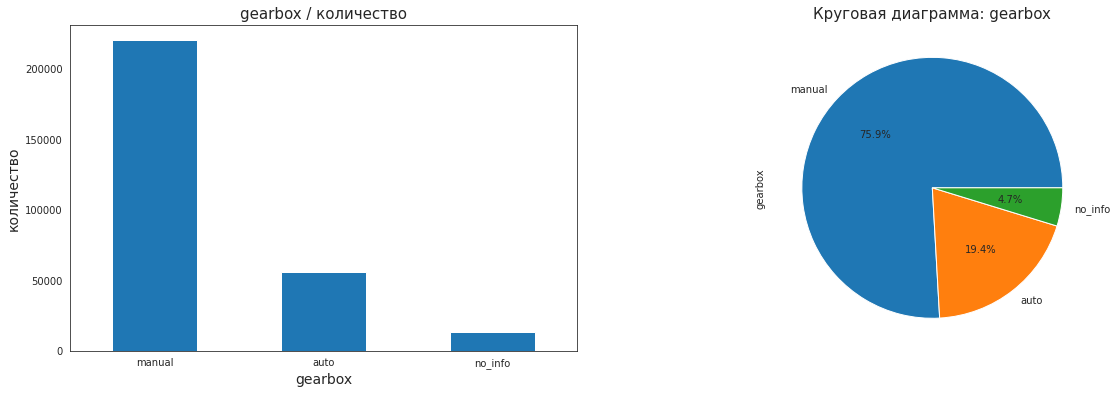

In [358]:
graphs_cat (data, 'gearbox')

Больше всего автомобилей с ручной коробкой передач, автомобилей на автомате ~ в 4 раза меньше.

### 'power' (мощность / л.с.)

In [359]:
data['power'].describe()

count    290121.000000
mean        112.293254
std         196.536599
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Отметим, что в данных есть автомобили с нулевой мощностью (возможно, это те самые раритетные авто 1000-го года регистрации без двигателя), а также машины с очень мальнькой мощностью. Максимальная мощность автомобиля в двтвсете - 20 000 л.с.

Для справки: *cамая маломощная машина в мире* имеет мощность 4.2 л.с. - это попавший в книгу рекордов Гиннеса как самый маленький из когда-либо производившихся автомобиль Peel P50. *Самая мощная машина в мире* на сегодняшний день - это гигантский американский карьерный самосвал Caterpillar 797F с мощностью 4000 л.с.

Изучим данные и определим выбросы.

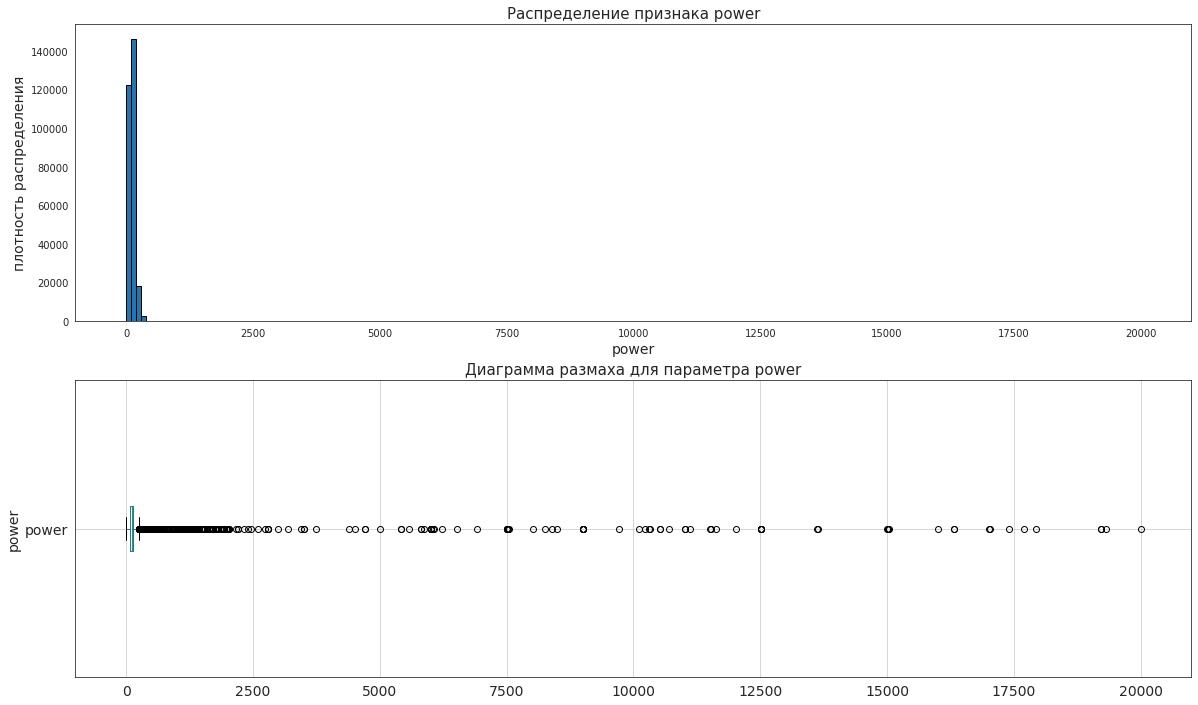

In [360]:
graphs_col (data, 'power', 200)

(0.0, 250.0)

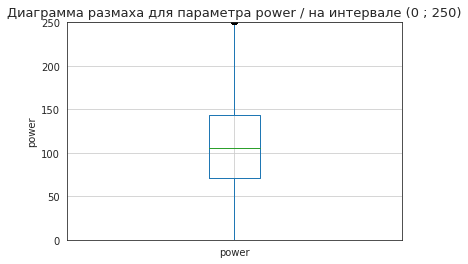

In [361]:
# зададим ограничения, чтобы отсечь все выбросы и определить верхнюю и нижнюю границы отсечения данных
data.boxplot(column='power')
plt.title('Диаграмма размаха для параметра power / на интервале (0 ; 250)', fontsize=13)
plt.ylabel('power')
plt.ylim(0, 250)

Найдем количество строк с нулевой мощностью.

In [362]:
print('Всего строк с нулевой мощностью:', len(data.query('power == 0')))
print('Количество строк с нулевой мощностью составляет', round(len(data.query('power == 0')) / len(data) * 100,2), '% от всего датафрейма')

Всего строк с нулевой мощностью: 30353
Количество строк с нулевой мощностью составляет 10.46 % от всего датафрейма


Отметим, что количество строк с нулевой мощностью двигателя значительно. Можно предположить, что произошла ошибка при выгузке данных или пользователь просто не указал данную информацию. Для избежании потери данных, оптимальным решением в данном случае будет *заменить нули медианным значением мощности по бренду*.

In [363]:
data['power'] = data.groupby('brand')['power'].transform(lambda x: x.replace(0, x.median()))

In [364]:
# проведем проверку
print('Всего строк с нулевой мощностью:', len(data.query('power == 0')))
print('Количество строк с нулевой мощностью составляет', round(len(data.query('power == 0')) / len(data) * 100,2), '% от всего датафрейма')

Всего строк с нулевой мощностью: 0
Количество строк с нулевой мощностью составляет 0.0 % от всего датафрейма


Далее найдем общее количество выбросов (автомобили с мощностью больше 250 л.с. и меньше 5 л.с.)

In [365]:
print('Всего строк с выбросами:', len(data.query('power > 250 or power < 5')))
print('Количество строк с выбросами составляет', round(len(data.query('power > 250 or power < 5')) / len(data) * 100,2), '% от всего датафрейма')

Всего строк с выбросами: 6273
Количество строк с выбросами составляет 2.16 % от всего датафрейма


Оптимальным решением будет отбросить данные об автомобилях с мощностью больше 250 л.с. и меньше 5 л.с.

---
***Строки с выбросами (мощностью > 250 л.с. и < 5 л.с.) будут удалены.***

### 'model' (модель автомобиля)

In [366]:
len(data['model'].unique())

249

Всего в данных содержится 249 уникальных моделей автомобилей.

### 'kilometer' (пробег / км)

In [367]:
data['kilometer'].describe()

count    290121.000000
mean     127428.021412
std       37954.339143
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

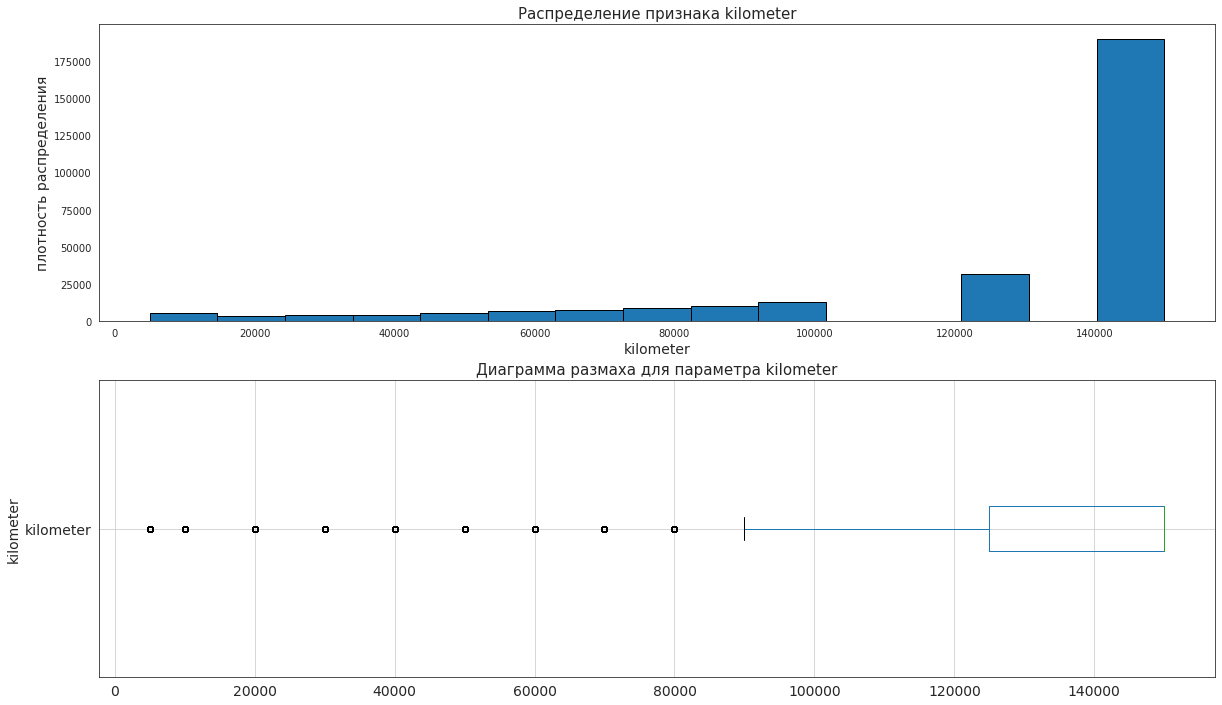

In [368]:
graphs_col (data, 'kilometer', 15)

Аномальных значений не выявлено. Отметим, что согласно нашим данным, минимальный пробег автомобиля составляет 5 тыс.км., максимальный - 150 тыс.км. Данные реалистичные.

Также (для справки) отметим, что по данным сервиса drom.ru среднегодовой пробег легковых автомобилей в России составляет 18 700 км (данные за 2022г. / подсчет сделан на основе анализа 400 тыс. объявлений о продаже машин в возрасте до пяти лет, исключая автомобили с признаками скрученного пробега).

### 'fuel_type' (тип топлива)

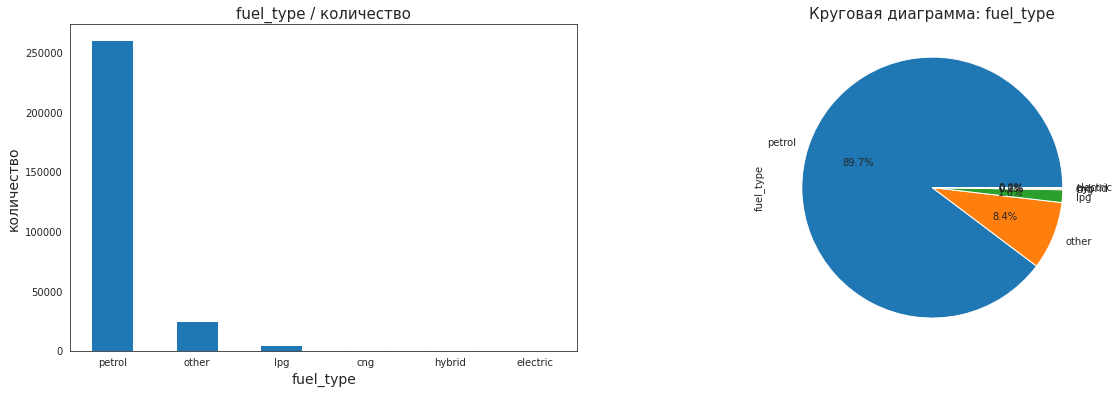

In [369]:
graphs_cat (data, 'fuel_type')

In [370]:
data.groupby('fuel_type')['fuel_type'].count().sort_values(ascending=False)

fuel_type
petrol      260307
other        24486
lpg           4559
cng            507
hybrid         197
electric        65
Name: fuel_type, dtype: int64

Больше всего автомобилей - на бензине, меньше всего электрокаров.

### 'brand' (марка автомобиля)

In [371]:
len(data['brand'].unique())

39

Всего в данных содержится 39 уникальных марок автомобилей.

### 'repaired' (была машина в ремонте или нет)

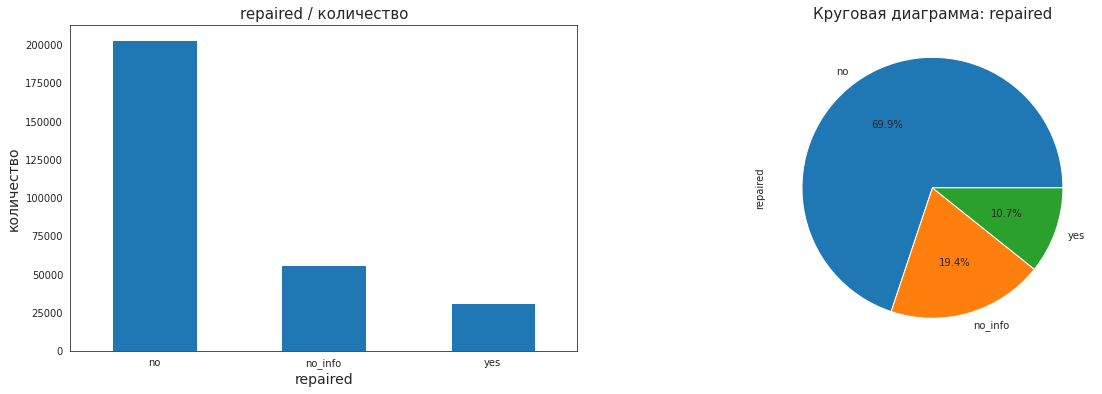

In [372]:
graphs_cat (data, 'repaired')

In [373]:
data.groupby('repaired')['repaired'].count().sort_values(ascending=False)

repaired
no         202729
no_info     56273
yes         31119
Name: repaired, dtype: int64

Большинство машин "не биты, не крашены" - в ремонте не были.

---
Итак, исследовательский анализ проведен.

Из дальнейшего рассмотрения удалим следующие данные:
    
* "бесплатные" автомобили
* автомобили с регистрацией после 2024 года и до 1985 года
* автомобили мощностью > 250 л.с. и < 5 л.с.

In [374]:
# сохраним количество строк в датафрейме до преобразований
before_analysis = len(data)
before

354369

In [375]:
data = data.query('price > 0')

In [376]:
data = data.query('registration_year >= 1985 and registration_year <= 2024')

In [377]:
data = data.query('power < 250 and power > 5')

In [378]:
after_analysis = len(data)
after_analysis

272403

In [379]:
print('РЕЗУЛЬТАТЫ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА:')
print(' ')
print('До преобразований в датафрейме было', before_analysis, 'строк')
print('После преобразований в датафрейме стало', after_analysis, 'строк')
print('-------------------------------------------------------------------------')
print('Всего было удалено', before_analysis - after_analysis, 'строк')
print('Количество удаленных строк составляет', round(((before_analysis - after_analysis) / before_analysis)*100, 2), '% от всего датафрейма')

РЕЗУЛЬТАТЫ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА:
 
До преобразований в датафрейме было 290121 строк
После преобразований в датафрейме стало 272403 строк
-------------------------------------------------------------------------
Всего было удалено 17718 строк
Количество удаленных строк составляет 6.11 % от всего датафрейма


---
Таким образом в результате полной обработки данных (это подготовка данных: работа с пропусками и дубликатами, работа с выбросами по результатами исследовательского анализа) имеем следующее:

In [380]:
print('РЕЗУЛЬТАТЫ ОБРАБОТКИ ДАННЫХ (работа с пропусками, дубликатами, выбросами):')
print(' ')
print('До всех преобразований в исходном датафрейме было', before, 'строк')
print('После преобразований в датафрейме стало', after_analysis, 'строк')
print('-------------------------------------------------------------------------')
print('Всего было удалено', before - after_analysis, 'строк')
print('Количество удаленных строк составляет', round(((before - after_analysis) / before)*100, 2), '% от всего датафрейма')

РЕЗУЛЬТАТЫ ОБРАБОТКИ ДАННЫХ (работа с пропусками, дубликатами, выбросами):
 
До всех преобразований в исходном датафрейме было 354369 строк
После преобразований в датафрейме стало 272403 строк
-------------------------------------------------------------------------
Всего было удалено 81966 строк
Количество удаленных строк составляет 23.13 % от всего датафрейма


---
**ВЫВОД: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ**

Был проведен исследовательский анализ данных датафрейма data.

На диаграмме размаха *цены* видим выбросы после ~ 14 800 EUR. Максимальная цена на автомобиль в выборке составляет 20 тыс EUR, минимальная - 0 EUR. Из дальнейшего рассмотрения исключили только "бесплатные автомобили", поскольку в действительности цены на автомобиль в диапазоне 15-20 тыс EUR выбросами не являются, это реальная цена на хороший б/у автомобиль. Количество строк с бесплатными автомобилями составило 7 191 (2.48 %).

Самый популярный *тип автомобильного кузова* - седан, наименьшей популярностью пользуется тип кузова suv).

На диаграмме размаха *года регистрации автомобиля* видим выбросы до 1985 г. Отметим, что в данных есть автомобили, зарегистрированные в 1000 году, максимальный год регистрации - 9 000. Данные об автомобилях с регистрацией после 2024 года и до 1985 года отбросили - 2951 строк (1.02 %).

*Тип коробки передач*: больше всего автомобилей на ручнике, автомобилей на автомате ~ в 4 раза меньше.

В данных есть автомобили с нулевой, а также машины с очень мальнькой *мощностью*. Максимальная мощность автомобиля в датасете - 20 000 л.с. Как известно, cамая маломощная машина в мире имеет мощность 4.2 л.с., а самая мощная машина 4000 л.с. Согласно диаграмме размаха, выбросы - значения после 250 л.с. Было выявлено значительное количество строк с нулевой мощностью: 30 353 (10.46 %). Для избежании потери данных произвели замену нелевых значений медианным значением мощности по бренду. Данные об автомобилях с мощностью больше 250 л.с. и меньше 5 л.с. исключили из рассмотрения - 6273 (2.16 %).

Всего в данных содержится 249 уникальных *моделей автомобилей*.

При анализе *пробега авто* аномальных значений не выявлено. Минимальный пробег автомобиля составляет 5 тыс.км., максимальный - 150 тыс.км. Данные реалистичные.

*Тип топлива*: больше всего автомобилей - на бензине 89.7, меньше всего электрокаров.

Всего в данных содержится 39 уникальных *марок автомобилей*.

*Была машина в ремонте или нет*: большинство машин "не биты, не крашены" - в ремонте не были.

---
***В результате всех преобразований (работа с пропусками, дубликатами, выбросами) удалено существенное количество данных - 81 966 строк (23.13 % данных исходного датафрейма), но такие результаты логичны и обоснованы.***

В результате *обработки пропусков* было удалено 19 705 строк ( 5.56 % от всего датафрейма). Удалены пропуски были только в столбце 'model' (19 705 пропусков / 5.56 % от всего датафрейма), поскольку этот параметр очень сильно влияет на ценообразование, а логичную замену подобрать не представляется возможным. В остальных столбцах все пропущенные значения мы заменили 

После *удаления неинформативных признаков было выявлено большое количество явных дубликатов (45 040)*, что логично, поскольку такие признаки как дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты пользователя, дата последней активности пользователя не влияют на ценообразование. В результате *общее количество дубликатов* составило 44 543 (13.31 % от всего датафрейма).

После *работы с выбросами по результатам исследовательского анализа* было удалено 17 718 строк (6.11 % от всего датафрейма)

## Шаг 4. Корреляционный анализ

Для того, чтобы выяснить, нет ли утечки целевого признака, а также лучше понять наши данные, проведем корреляционный анализ.  
Так как не все количественные признаки имеют нормальное распределение, будем использовать модуль phik.

In [381]:
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


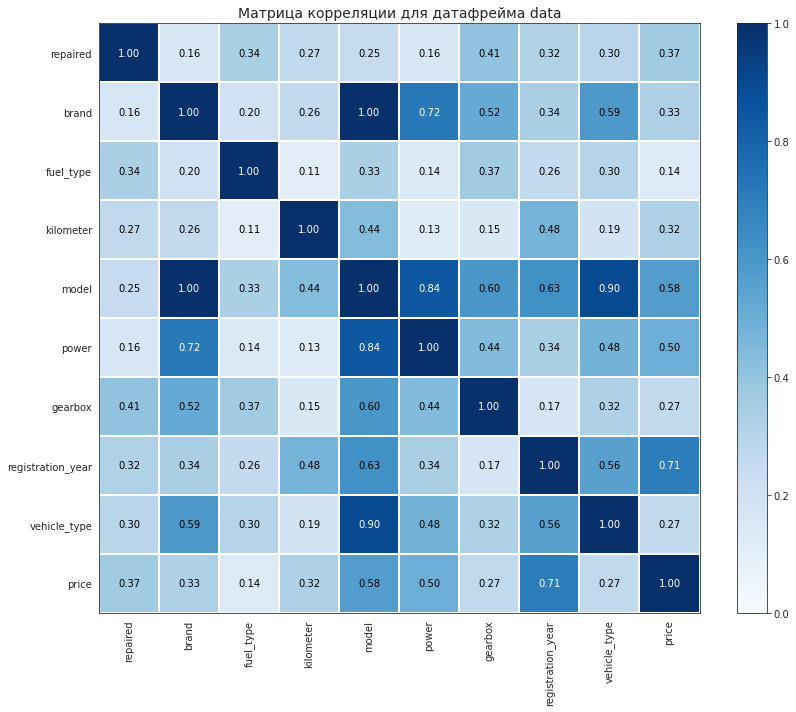

In [382]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title='Матрица корреляции для датафрейма data',
    figsize=(12, 10)
)
plt.show()

Матрица корреляции для датафрейма data построена.  
Рассмотрим ***корреляцию целевого признака 'price' (цена) с остальными:***

*сильная* корреляция с параметром:
* 'registration_year' / год регистрации автомобиля (= 0.70)

*заметная* корреляция с параметром:
* 'model' / модель автомобиля (= 0.58)
* 'power' / мощность (= 0.50)

*умеренная* корреляция с параметрами:  
* 'repaired' / была машина в ремонте или нет (= 0.37)  
* 'brand' / марка автомобиля (= 0.33)  
* 'kilometer' / пробег (= 0.32)  

---
Рассмотрим ***корреляцию корреляцию признаков между собой:***

*Очень сильную* корреляцию мы видим между признаками:
* 'vehicle_type'(тип автомобильного кузова) // 'model' (модель автомобиля) = 0.9
* 'model' (модель автомобиля) // 'brand' (марка автомобиля) = 1

*Сильную* корреляцию мы видим между признаками:
* 'power' (мощность) // 'brand' (марка автомобиля) = 0.72
* 'power' (мощность) // 'model' (модель автомобиля) = 0.84

*Заметная* корреляция между признаками:
* 'gearbox' (тип коробки передач) // 'brand' (марка автомобиля) = 0.52
* 'vehicle_type'(тип автомобильного кузова) // 'brand' (марка автомобиля) = 0.59
* 'gearbox' (тип коробки передач) // 'model' (модель автомобиля) = 0.60
* 'registration_year' (год регистрации автомобиля) // 'model' (модель автомобиля) = 0.63
* 'vehicle_type'(тип автомобильного кузова) // 'registration_year' (год регистрации автомобиля) = 0.56

*Умеренная* корреляция между признаками:
* 'fuel_type' (тип топлива) // 'repaired' (была машина в ремонте или нет) = 0.34
* 'gearbox' (тип коробки передач) // 'repaired' (была машина в ремонте или нет) = 0.41
* 'registration_year' (год регистрации автомобиля) // 'repaired' (была машина в ремонте или нет) = 0.32
* 'vehicle_type'(тип автомобильного кузова) // 'repaired' (была машина в ремонте или нет) = 0.30
* 'registration_year' (год регистрации автомобиля) // 'brand' (марка автомобиля) = 0.34
* 'model' (модель автомобиля) // 'fuel_type' (тип топлива) = 0.33
* 'gearbox' (тип коробки передач) // 'fuel_type' (тип топлива) = 0.37
* 'vehicle_type'(тип автомобильного кузова) // 'fuel_type' (тип топлива) = 0.30
* 'model' (модель автомобиля) // 'kilometer' (пробег) = 0.44
* 'registration_year' (год регистрации автомобиля) // 'kilometer' (пробег) = 0.48
* 'gearbox' (тип коробки передач) // 'power' (мощность) = 0.44
* 'registration_year' (год регистрации автомобиля) // 'power' (мощность) = 0.34
* 'vehicle_type'(тип автомобильного кузова) // 'power' (мощность) = 0.48
* 'vehicle_type'(тип автомобильного кузова) // 'gearbox' (тип коробки передач) = 0.32

---
Все связи между признаками логичны и закономерны. Можно сказать, что утечки целевого признака не обнаружено.

---
**ВЫВОД: КОРРЕЛЯЦИОННЫЙ АНАЛИЗ**

Был проведен корреляционный анализ данных датафрейма data.

В результате корреляционного анализа было выявлено, что цена (целевой признак) сильно зависит от года регистрации авто (сильная корреляция), существенно зависит от модели авто и его мощности (заметная корреляция). Также есть зависимость между ценой и тем, была ли машина в ремонте, маркой авто и пробегом (умеренная корреляция).

Также была замечена очень сильная связь между типом автомобильного кузова и моделью, моделью и маркой автомобиля (очень сильная корреляция). Сильная свзь между мощностью и маркой, мощностью и моделью (сильная корреляция).

Существенная зависимость (заметная корреляция) между: типом коробки передач / маркой и моделью авто, типом кузова / маркой, годом регистрации / моделью и типом автомобильного кузова.

Также замечена зависимость (умеренная корреляция) между тем, была машина в ремонте или нет / такими ее характеристиками, как тип топлива, коробки, кузова, год регистрации. Год регистрации авто имеет умеренную зависимость с маркой, пробегом и мощностью. Тип топлива умеренно коррелирует с моделью, типом коробки и кузова авто. Есть умеренная зависимость между типом кузова и мощностью, типом коробки, при этом мощность и тип коробки передач также между собой умеренно коррелируют. Пробег умеренно зависит от модели авто.

---
В целом все данные выглядят реалистично, все связи между признаками логичны и закономерны.  
Утечки целевого признака не обнаружено.

## Шаг 5. Обучение моделей

На этом этапе обучим несколько моделей с различными гиперпараметрами.

Все полученные результаты (модель, рассчитанную метрику RMSE для каждой модели, время обучения, время предсказания) будем сохранять в массив result.

In [383]:
result = []

>В целях оптимизации кода для сохранения и вывода результатов создадим функцию **print_res**:  

In [384]:
def print_res (model_name, model, rmse, time_fit, time_pred):
    
    result.append([model_name, model, round(rmse,2), round(time_fit,2), round(time_pred,2)])
    
    print(f'Результаты для модели {model_name}')
    print('-------------------------------------------')
    print('Качество предсказания / RMSE =', round(rmse,2))
    print('Время обучения модели:', round(time_fit,2), 'сек')
    print('Время предсказания модели:', round(time_pred,2), 'сек')

### Подготовка данных

In [385]:
RANDOM_STATE = 42

In [386]:
# сохраним входные и целевой признаки
X = data.drop('price', axis=1)
y = data['price']

In [387]:
# разделим входные и целевой признаки на тренировочную, тестовую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [388]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [389]:
X_train.shape, X_val.shape, X_test.shape

((174337, 9), (43585, 9), (54481, 9))

Кодировщик OneHotEncoder подойдет для линейной модели, для всех других моделей будем использовать OrdinalEncoder.

Таким образом, сделаем 2 отдельных набора данных (OHE для LinearRegression, OE - для остальных моделей).

In [390]:
# создадим списки с названиями признаков
cat_col_names = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_col_names = ['registration_year', 'power', 'kilometer']

In [391]:
# масштабируем количественные признаки с помощью StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_val_scaled = scaler.transform(X_val[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [392]:
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((174337, 3), (43585, 3), (54481, 3))

In [393]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

* ***Кодировка категориальных признаков помощи OneHotEncoder + создание первого набора данных***

In [394]:
# кодируем категориальные признаки с помощью OneHotEncoder
encoder_ohe = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder_ohe.fit_transform(X_train[cat_col_names])
X_val_ohe = encoder_ohe.transform(X_val[cat_col_names])
X_test_ohe = encoder_ohe.transform(X_test[cat_col_names])
encoder_col_names = encoder_ohe.get_feature_names_out()

In [395]:
# собираем выборки 
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_val_ohe = pd.DataFrame(X_val_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [396]:
X_train_ohe = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_val_ohe = pd.concat([X_val_ohe, X_val_scaled], axis=1)
X_test_ohe = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [397]:
X_train_ohe.shape, X_val_ohe.shape, X_test_ohe.shape

((174337, 302), (43585, 302), (54481, 302))

* ***Кодировка категориальных признаков помощи OrdinalEncoder + создание второго набора данных***

In [398]:
# кодируем категориальные признаки с помощью OrdinalEncoder
encoder_oe = OrdinalEncoder()
X_train_oe = encoder_oe.fit_transform(X_train[cat_col_names])
X_val_oe = encoder_oe.transform(X_val[cat_col_names])
X_test_oe = encoder_oe.transform(X_test[cat_col_names])
encoder_col_names = encoder_oe.get_feature_names_out()

In [399]:
# собираем выборки 
X_train_oe = pd.DataFrame(X_train_oe, columns=encoder_col_names)
X_val_oe = pd.DataFrame(X_val_oe, columns=encoder_col_names)
X_test_oe = pd.DataFrame(X_test_oe, columns=encoder_col_names)

In [400]:
X_train_oe = pd.concat([X_train_oe, X_train_scaled], axis=1)
X_val_oe = pd.concat([X_val_oe, X_val_scaled], axis=1)
X_test_oe = pd.concat([X_test_oe, X_test_scaled], axis=1)

In [401]:
X_train_oe.shape, X_val_oe.shape, X_test_oe.shape

((174337, 9), (43585, 9), (54481, 9))

---
Итак, на этом этапе мы получили 2 набора данных:

* X_train_ohe, X_val_ohe, X_test_ohe (для LinearRegression)
* X_train_oe, X_val_oe, X_test_oe (для остальных моделей)

### LinearRegression

In [402]:
# обучим модель линейной регрессии
model_lr = LinearRegression()

In [403]:
%%time
# найдем время обучения
start = time.time()

model_lr.fit(X_train_ohe, y_train)

end = time.time()
time_fit_lr = end-start

CPU times: user 11.4 s, sys: 3.66 s, total: 15.1 s
Wall time: 15.4 s


In [404]:
%%time
# построим предсказания на валидационной выборке
# найдем время предсказания
start = time.time()

predictions = model_lr.predict(X_val_ohe)

end = time.time()
time_pred_lr = end-start

CPU times: user 83.9 ms, sys: 67.6 ms, total: 152 ms
Wall time: 221 ms


In [405]:
# найдем корень из среднеквадратичной ошибки (RMSE)
rmse_lr = mean_squared_error(y_val, predictions)**0.5

In [406]:
print_res('LinearRegression', model_lr, round(rmse_lr,2), round(time_fit_lr,2), round(time_pred_lr,2))

Результаты для модели LinearRegression
-------------------------------------------
Качество предсказания / RMSE = 2438.34
Время обучения модели: 15.35 сек
Время предсказания модели: 0.22 сек


### DecisionTreeRegressor

Будем обучать модель, подбирая наилучшую глубину. Все полученные результаты (глубину, соответствующую метрику RMSE, время обучения) будем сохранять в массив result_dtc.

In [407]:
result_dtr = []

In [408]:
# найдем лучшие гиперпараметры для глубины дерева
for depth in range(3, 20, 3):
    
    model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = depth)
    model.fit(X_train_oe, y_train)
    
    predictions = model.predict(X_val_oe)
    rmse = mean_squared_error(y_val, predictions)**0.5
    
    result_dtr.append([depth, rmse])
    print('Глубина:', depth)
    print('RMSE:', rmse)
    print('')

Глубина: 3
RMSE: 2880.084144427992

Глубина: 6
RMSE: 2253.422988379675

Глубина: 9
RMSE: 1973.280279808925

Глубина: 12
RMSE: 1877.8005298252608

Глубина: 15
RMSE: 1881.424924052525

Глубина: 18
RMSE: 1938.5686078388585



In [409]:
result_dtr = pd.DataFrame(result_dtr, columns=['depth', 'RMSE']).sort_values(by='RMSE')
result_dtr

,depth,RMSE
3,12,1877.800530
4,15,1881.424924
5,18,1938.568608
2,9,1973.280280
1,6,2253.422988
0,3,2880.084144


In [410]:
# первая строка датафрейма result_dtr - это глубина, при котором модель показала наилучшее значение RMSE
best_depth = result_dtr.iloc[0, 0]
rmse_dtr = result_dtr.iloc[0, 1]

In [411]:
# сохраним лучшую модель DecisionTreeClassifier
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = best_depth)

In [412]:
%%time
# найдем время обучения
start = time.time()

model_dtr.fit(X_train_oe, y_train)

end = time.time()
time_fit_dtr = end-start

CPU times: user 389 ms, sys: 242 µs, total: 390 ms
Wall time: 397 ms


In [413]:
%%time
# построим предсказания на тренировочной выборке
# найдем время предсказания
start = time.time()

predictions = model_dtr.predict(X_val_oe)

end = time.time()
time_pred_dtr = end-start

CPU times: user 9.67 ms, sys: 0 ns, total: 9.67 ms
Wall time: 22.1 ms


In [414]:
print_res('DecisionTreeRegressor', model_dtr, round(rmse_dtr,2), round(time_fit_dtr,2), round(time_pred_dtr,2))

Результаты для модели DecisionTreeRegressor
-------------------------------------------
Качество предсказания / RMSE = 1877.8
Время обучения модели: 0.4 сек
Время предсказания модели: 0.02 сек


### RandomForestRegressor

In [415]:
# в первой верссии проекта (код ниже) рассматривала разное количество деревьев в модели
# выяснилось, что значения RMSE для количества деревьев 100, 500 и 1000 отличаются несущественно
# сейчас для ускорения работы кода рассматриваю только 100 деревьев:
# for estimator in [100, 500, 1000]:
#        model = RandomForestRegressor(random_state=RANDOM_STATE, 
#                                      n_estimators=estimator,
#                                      max_depth=9)   
#        model.fit(X_train, y_train)
#        predictions = model.predict(X_train)    
#        rmse = mean_squared_error(y_train, predictions)**0.5
#        print('Количество деревьев:', estimator)
#        print('RMSE:', rmse)
#        print('')

In [416]:
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE, 
                                  n_estimators=100,
                                  max_depth=9)

In [417]:
%%time
# найдем время обучения
start = time.time()

model_rfr.fit(X_train_oe, y_train)

end = time.time()
time_fit_rfr = end-start

CPU times: user 20 s, sys: 39.9 ms, total: 20 s
Wall time: 20 s


In [418]:
%%time
# построим предсказания на тренировочной выборке
# найдем время предсказания
start = time.time()

predictions = model_rfr.predict(X_val_oe)

end = time.time()
time_pred_rfr = end-start

CPU times: user 335 ms, sys: 201 µs, total: 335 ms
Wall time: 341 ms


In [419]:
rmse_rfr = mean_squared_error(y_val, predictions)**0.5

In [420]:
print_res('RandomForestRegressor', model_rfr, round(rmse_rfr,2), round(time_fit_rfr,2), round(time_pred_rfr,2))

Результаты для модели RandomForestRegressor
-------------------------------------------
Качество предсказания / RMSE = 1886.15
Время обучения модели: 20.03 сек
Время предсказания модели: 0.34 сек


### CatBoostRegressor

In [421]:
model = CatBoostRegressor() 

parameters = [{'learning_rate':[0.1, 0.4, 0.9],
               'random_state':[RANDOM_STATE],
               'verbose':[False]}] 

gscv = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
gscv.fit(X_train_oe, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fe5d4e6fe50>,
             param_grid=[{'learning_rate': [0.1, 0.4, 0.9],
                          'random_state': [42], 'verbose': [False]}],
             scoring='neg_mean_squared_error')

In [422]:
print('Лучшие параметры:', gscv.best_params_)

Лучшие параметры: {'learning_rate': 0.4, 'random_state': 42, 'verbose': False}


In [423]:
model_cbr = gscv.best_estimator_

In [424]:
%%time
# найдем время обучения
start = time.time()

model_cbr.fit(X_train_oe, y_train)

end = time.time()
time_fit_cbr = end-start

CPU times: user 22.5 s, sys: 127 ms, total: 22.6 s
Wall time: 23.5 s


In [425]:
%%time
# построим предсказания на тренировочной выборке
# найдем время предсказания
start = time.time()

predictions = model_cbr.predict(X_val_oe)

end = time.time()
time_pred_cbr = end-start

CPU times: user 45 ms, sys: 37 µs, total: 45.1 ms
Wall time: 43.4 ms


In [426]:
rmse_cbr = mean_squared_error(y_val, predictions)**0.5

In [427]:
print_res('CatBoostRegressor', model_cbr, round(rmse_cbr,2), round(time_fit_cbr,2), round(time_pred_cbr,2))

Результаты для модели CatBoostRegressor
-------------------------------------------
Качество предсказания / RMSE = 1534.7
Время обучения модели: 23.5 сек
Время предсказания модели: 0.04 сек


### LightGBM

In [429]:
# в первой версии проекта (код ниже) искала наилучшие гиперпараметры с помощью GridSearchCV
# сейчас для ускорения работы сразу возьму результат из прошлой верии
# лучшие параметры были: 'n_estimators'=1000, 'num_leaves'=60
# param_grid = {'n_estimators': [100, 500, 1000],
#               'num_leaves': [n for n in range(20, 300, 20)]}
# model = lgb.LGBMRegressor(random_state=RANDOM_STATE)
# tuning_model=GridSearchCV(estimator=model,
#                           param_grid=param_grid,
#                           scoring='neg_root_mean_squared_error',
#                           cv=3,
#                           verbose=3)
# tuning_model.fit(X_train_oe, y_train)  

In [430]:
model_lgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE,
                          n_estimators=1000,
                          num_leaves=60)

In [431]:
%%time
# найдем время обучения
start = time.time()

model_lgbm.fit(X_train_oe, y_train)

end = time.time()
time_fit_lgbm = end-start

CPU times: user 41.6 s, sys: 282 ms, total: 41.9 s
Wall time: 42 s


In [432]:
%%time
# построим предсказания на тренировочной выборке
# найдем время предсказания
start = time.time()

predictions = model_lgbm.predict(X_val_oe)

end = time.time()
time_pred_lgbm = end-start

CPU times: user 5.15 s, sys: 9.48 ms, total: 5.16 s
Wall time: 5.29 s


In [433]:
rmse_lgbm = mean_squared_error(y_val, predictions)**0.5

In [434]:
print_res('LGBMRegressor', model_lgbm, round(rmse_lgbm,2), round(time_fit_lgbm,2), round(time_pred_lgbm,2))

Результаты для модели LGBMRegressor
-------------------------------------------
Качество предсказания / RMSE = 1516.08
Время обучения модели: 41.98 сек
Время предсказания модели: 5.29 сек


## Шаг 6. Выбор лучшей модели и проверка её качества

Подведем итоги проделанной работы.  Представим все полученные результаты в удобной для восприятия форме.  
Массив с результатами result преобразуем в датафрейм (result). Отсортируем результаты по возрастанию значения RMSE.

In [435]:
result = pd.DataFrame(result, columns=['model', 'model + parametres', 'RMSE', 'time_fit', 'time_pred'])
result = result.sort_values(by='RMSE')
result

,model,model + parametres,RMSE,time_fit,time_pred
4,LGBMRegressor,"LGBMRegressor(n_estimators=1000, num_leaves=60...",1516.08,41.98,5.29
3,CatBoostRegressor,<catboost.core.CatBoostRegressor object at 0x7...,1534.70,23.50,0.04
1,DecisionTreeRegressor,"DecisionTreeRegressor(max_depth=12, random_sta...",1877.80,0.40,0.02
2,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=9, max_featur...",1886.15,20.03,0.34
0,LinearRegression,LinearRegression(),2438.34,15.35,0.22


Отметим, что значение метрики качества меньше 2500 по всем пяти моделям (критерий выполняется).

* **найдем лучшую модель по показателю RMSE**

In [436]:
# первая строка датафрейма result - это лучшая модель по показателю RMSE
print(f'Лучшей моделью по показателю RMSE является {result.iloc[0, 0]} с показателями:')
print('-----------------------------------------------------------------------')
print(f'RMSE = {result.iloc[0, 2]}')
print(f'время обучения {result.iloc[0, 3]} сек')
print(f'время предсказания {result.iloc[0, 4]} сек')

Лучшей моделью по показателю RMSE является LGBMRegressor с показателями:
-----------------------------------------------------------------------
RMSE = 1516.08
время обучения 41.98 сек
время предсказания 5.29 сек


---
Заказчику, помимо качества предсказания, также важны критерии: время обучения модели, время предсказания модели.

* **найдем лучшую модель по показателю показателю 'time_fit' (время обучения)**

In [437]:
# первая строка датафрейма result_time_fit - это лучшая модель по показателю time_fit / время обучения
result_time_fit = result.sort_values(by='time_fit')
#result_time_fit

In [438]:
print(f'Лучшей моделью по показателю time_fit / время обучения является {result_time_fit.iloc[0, 0]} с показателями:')
print('-----------------------------------------------------------------------')
print(f'RMSE = {result_time_fit.iloc[0, 2]}')
print(f'время обучения {result_time_fit.iloc[0, 3]} сек')
print(f'время предсказания {result_time_fit.iloc[0, 4]} сек')

Лучшей моделью по показателю time_fit / время обучения является DecisionTreeRegressor с показателями:
-----------------------------------------------------------------------
RMSE = 1877.8
время обучения 0.4 сек
время предсказания 0.02 сек


* **найдем лучшую модель по показателю показателю 'time_pred' (время предсказания)**

In [439]:
# первая строка датафрейма result_time_pred - это лучшая модель по показателю time_pred / время предсказания
result_time_pred = result.sort_values(by='time_pred')
#result_time_pred

In [440]:
print(f'Лучшей моделью по показателю time_pred / время предсказания является {result_time_pred.iloc[0, 0]} с показателями:')
print(f'RMSE = {result_time_pred.iloc[0, 2]}')
print(f'время обучения {result_time_pred.iloc[0, 3]} сек')
print(f'время предсказания {result_time_pred.iloc[0, 4]} сек')

Лучшей моделью по показателю time_pred / время предсказания является DecisionTreeRegressor с показателями:
RMSE = 1877.8
время обучения 0.4 сек
время предсказания 0.02 сек


---
CatBoostRegressor по качеству предсказания находится на втором месте (c небольшим отставанием от лидера LightGBM и существенным отрывом от остальных моделей), при этом по времени обучения и предсказания модель показывает хорошие результаты.

LightGBM, несмотря на то, что занимает первое место по качеству предсказания, сильно проигрывает CatBoostRegressor по времени, при этом метрика RMSE у моделей отличается совсем незначительно.

**Принимая во внимание все критерии, которые важны заказчику (качество предсказания, время обучения и время предсказания), лучшей можно назвать модель CatBoostRegressor.**

In [441]:
print(f'С учетом всех критериев лучшей моделью является CatBoostRegressor с показателями:')
print('-----------------------------------------------------------------------')
print(f'RMSE = {rmse_cbr}')
print(f'время обучения {time_fit_cbr} сек')
print(f'время предсказания {time_pred_cbr} сек')

С учетом всех критериев лучшей моделью является CatBoostRegressor с показателями:
-----------------------------------------------------------------------
RMSE = 1534.7038071693603
время обучения 23.49717140197754 сек
время предсказания 0.04331493377685547 сек


---
* **Проверим качество лучшей модели (CatBoostRegressor) на тестовой выборке.**

In [442]:
%%time
# построим предсказания на тестовой выборке
# найдем время предсказания
start = time.time()

y_predict = model_cbr.predict(X_test_oe)

end = time.time()
time_pred_test = end-start
time_pred_test = round(time_pred_test, 2)
time_pred_test

CPU times: user 57.2 ms, sys: 4 µs, total: 57.2 ms
Wall time: 56.4 ms


0.06

In [443]:
rsme_test = mean_squared_error(y_test, y_predict) ** 0.5
rsme_test = round(rsme_test, 2)
rsme_test

1559.99

In [444]:
print('Результаты лучшец модели CatBoostRegressor на тестовых данных')
print('-------------------------------------------')
print(f'Качество предсказания лучшей модели на тестовой выборке / RMSE = {rsme_test} за время: {time_pred_test} сек')

Результаты лучшец модели CatBoostRegressor на тестовых данных
-------------------------------------------
Качество предсказания лучшей модели на тестовой выборке / RMSE = 1559.99 за время: 0.06 сек


Итак, лучшая модель (CatBoostRegressor) на тестовой выборке показала отличные результаты.

---
* **Также для лучшей модели (CatBoostRegressor) выведем важность признаков и построим график.**

In [445]:
importances = model_cbr.get_feature_importance()

In [446]:
feature_importances_df = pd.DataFrame({
    'Feature': X_test_oe.columns,
    'Importance': importances
})

In [447]:
# выводим результат / важность признаков
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

,Feature,Importance
6,registration_year,38.832391
7,power,23.544219
8,kilometer,10.409239
4,brand,9.925863
0,vehicle_type,6.591480
2,model,5.888358
5,repaired,3.377726
1,gearbox,1.134396
3,fuel_type,0.296328


<AxesSubplot:ylabel='Feature'>

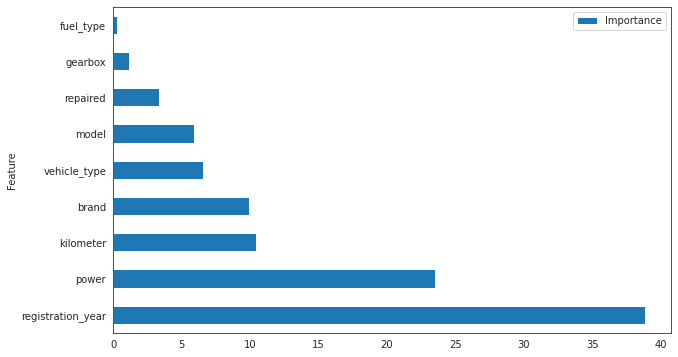

In [448]:
# представим результат графически
sns.set_style('white')
feature_importances_df.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Итак, можно заметить, что наиболее важным оказался признак 'registration_year' (год регистрации автомобиля), также довольно большое значение имеет мощность авто (признак 'power'), а тип топлива (признак 'fuel_type') на модель практически не влияет. 

**ВЫВОД: ОБУЧЕНИЕ МОДЕЛЕЙ + ВЫБОР ЛУЧШЕЙ МОДЕЛИ И ПРОВЕРКА ЕЕ КАЧЕСТВА**

Было проведено обучение пяти моделей: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor и LightGBM.  

Для каждой модели было найдено: метрика RMSE - качество предсказания, а также время обучения и время предсказания модели (то есть все обозначенные критерии, которые важны заказчику).

**Были получены следующие результаты:**

In [449]:
print(f'Лучшей моделью по показателю RMSE является {result.iloc[0, 0]} с показателями:')
print(f'RMSE = {result.iloc[0, 2]}, время обучения {result.iloc[0, 3]} сек, время предсказания {result.iloc[0, 4]} сек')
print('-----------------------------------------------------------------------')
print(f'Лучшей моделью по показателю time_fit / время обучения является {result_time_fit.iloc[0, 0]} с показателями:')
print(f'RMSE = {result_time_fit.iloc[0, 2]}, время обучения {result_time_fit.iloc[0, 3]} сек, время предсказания {result_time_fit.iloc[0, 4]} сек')
print('-----------------------------------------------------------------------')
print(f'Лучшей моделью по показателю time_pred / время предсказания является {result_time_pred.iloc[0, 0]} с показателями:')
print(f'RMSE = {result_time_pred.iloc[0, 2]}, время обучения {result_time_pred.iloc[0, 3]} сек, время предсказания {result_time_pred.iloc[0, 4]}')

Лучшей моделью по показателю RMSE является LGBMRegressor с показателями:
RMSE = 1516.08, время обучения 41.98 сек, время предсказания 5.29 сек
-----------------------------------------------------------------------
Лучшей моделью по показателю time_fit / время обучения является DecisionTreeRegressor с показателями:
RMSE = 1877.8, время обучения 0.4 сек, время предсказания 0.02 сек
-----------------------------------------------------------------------
Лучшей моделью по показателю time_pred / время предсказания является DecisionTreeRegressor с показателями:
RMSE = 1877.8, время обучения 0.4 сек, время предсказания 0.02


CatBoostRegressor по качеству предсказания находится на втором месте (c небольшим отставанием от лидера LightGBM и существенным отрывом от остальных моделей), при этом по времени обучения и предсказания модель показывает хорошие результаты.

LightGBM, несмотря на то, что занимает первое место по качеству предсказания, сильно проигрывает CatBoostRegressor по времени, при этом метрика RMSE у моделей отличается совсем незначительно.

**Принимая во внимание все критерии, которые важны заказчику (качество предсказания, время обучения и время предсказания), лучшей можно назвать модель CatBoostRegressor.**

In [450]:
print(f'С учетом всех критериев лучшей моделью является CatBoostRegressor с показателями:')
print(f'RMSE = {round(rmse_cbr,2)}, время обучения {round(time_fit_cbr,2)} сек, время предсказания {round(time_pred_cbr,2)} сек')
print('-------------------------------------------')
print(f'Качество предсказания лучшей модели на тестовой выборке / RMSE = {rsme_test} за время: {time_pred_test} сек')

С учетом всех критериев лучшей моделью является CatBoostRegressor с показателями:
RMSE = 1534.7, время обучения 23.5 сек, время предсказания 0.04 сек
-------------------------------------------
Качество предсказания лучшей модели на тестовой выборке / RMSE = 1559.99 за время: 0.06 сек


*Был проведен анализ важности признаков*, результаты представлены графически. Наиболее важным оказался признак 'registration_year' (год регистрации автомобиля), также довольно большое значение имеет мощность авто (признак 'power'), а тип топлива (признак 'fuel_type') на модель практически не влияет.

## Шаг 8. Общий вывод

**Задачи исследования**

* провести предобработку и анализ данных
* подготовить данные
* обучить модели с использованием разных гиперпараметров
* провести анализ времени обучения, времени предсказания и качества моделей
* выбрать лучшую модель, проверить её качество на тестовой выборке
* сформулировать выводы

---
**Цель исследования** - построить модель для определения стоимости автомобиля на основании данных о технических характеристиках, комплектации и ценах других автомобилей

---
**Данные для анализа** - файл с данными */datasets/autos.csv*

---
**ШАГ 1 / ЗАГРУЗКА И ИЗУЧЕНИЕ ОБЩЕЙ ИНФОРМАЦИИ**

Итак, мы считали CSV-файл с данными и сохранили его в датафрейм data.

В датафрейме data содержится: 354 369 строк / 16 столбцов.  
Каждая строка = автомобиль, каждый столбец = параметр, который содержит информацию об автомобиле.

В данных содержатся неиформативные признаки, которые не влияют на цену, следовательно, не понадобятся для обучения модели: 'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen' //*удалим на этапе подготовки данных*

Наименования всех столбцов оптимально привести к "змеиному стилю".

В столбцах 'DateCrawled', 'DateCreated', 'LastSeen' было бы оптимально изменить тип данных с 'object' на 'datatime', но это неактуально, т.к. эти признаки будут удалены как неинформативные. Таким образом, тип данных - корректный во всх столбцах, преобразования не требуются.

Пропуcки присутствуют в столбцах: 'VehicleType' - 37 490 пропусков, 'Gearbox' - 19 833, 'Model' - 19 705, 'FuelType' - 32 895, 'Repaired' - 71 154.

Количество явных дубликатов: 4

---
**ШАГ 2 / ПОДГОТОВКА ДАННЫХ**

Были удалены следующие неинформативные признаки: 'date_crawled' (дата скачивания анкеты из базы), 'registration_month' (месяц регистрации автомобиля), 'date_created' (дата создания анкеты), 'number_of_pictures' (количество фотографий автомобиля), 'postal_code' (почтовый индекс владельца анкеты пользователя), 'last_seen' (дата последней активности пользователя).

---
Приведены к "змеиному стилю" наименования всех столбцов

---
Пропуски были удалены только *в столбце 'model'* (19 705 пропусков / 5.56 % от всего датафрейма), поскольку этот параметр очень сильно влияет на ценообразование, а логичную замену подобрать не представляется возможным. Так как в дальнейшем это может оказать значительное влияние на модель, пропущенные значения предпочтительнее удалить, чем заполнить некорректной / неточной информацией.

В столбце *'vehicle_type'* заполнили все пропуски значением 'other' (количество пропусков: 37 490 / 10.58 %)

В столбце *'gearbox'* добавили третий признак - заполнили пропуски значением 'no_info', предположив, что пропуски в данных стоят вместо роботизированной и вариативной коробок передач (количество пропусков: 19 833 / 5.6 % от всего датафрейма)

В столбце *'fuel_type'* заполнили все пропуски значением 'other' (количество пропусков: 25 732 / 7.69 %)

В столбце *'repaired'* добавили третий признак - заполнили пропуски значением 'no_info', учитывая то, что в дальнейшем при использовании модели и сборе новых данных может возникнуть ситуация, когда, действительно, нет информации о том, ремонтировалась ли машина или нет (количество пропусков: 62 100 / 18.56 %)

---
Проведена работа с дубликатами 

После удаления неинформативных признаков количество явных дубликатов увеличилось с 4 до 45 040, что логично.

В данных были обнаружены неявные дубликаты (данные приведены в соответствие):
'rangerover' / 'range_rover' в столбце 'model' (два разных написания названия одной модели),
'petrol' и 'gasoline' в столбце 'fuel_type' (одно и то же топливо - бензин).

В результате общее количество дубликатов составило 44543 (13.31 %). Все дубликаты удалены.

---
**ШАГ 3 / ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ**

Был проведен исследовательский анализ данных датафрейма data.

На диаграмме размаха *цены* видим выбросы после ~ 14 800 EUR. Максимальная цена на автомобиль в выборке составляет 20 тыс EUR, минимальная - 0 EUR. Из дальнейшего рассмотрения исключили только "бесплатные автомобили", поскольку в действительности цены на автомобиль в диапазоне 15-20 тыс EUR выбросами не являются, это реальная цена на хороший б/у автомобиль. Количество строк с бесплатными автомобилями составило 7 191 (2.48 %).

Самый популярный *тип автомобильного кузова* - седан, наименьшей популярностью пользуется тип кузова suv).

На диаграмме размаха *года регистрации автомобиля* видим выбросы до 1985 г. Отметим, что в данных есть автомобили, зарегистрированные в 1000 году, максимальный год регистрации - 9 000. Данные об автомобилях с регистрацией после 2024 года и до 1985 года отбросили - 2951 строк (1.02 %).

*Тип коробки передач*: больше всего автомобилей на ручнике, автомобилей на автомате ~ в 4 раза меньше.

В данных есть автомобили с нулевой, а также машины с очень мальнькой *мощностью*. Максимальная мощность автомобиля в датасете - 20 000 л.с. Как известно, cамая маломощная машина в мире имеет мощность 4.2 л.с., а самая мощная машина 4000 л.с. Согласно диаграмме размаха, выбросы - значения после 250 л.с. Было выявлено значительное количество строк с нулевой мощностью: 30 353 (10.46 %). Для избежании потери данных произвели замену нелевых значений медианным значением мощности по бренду. Данные об автомобилях с мощностью больше 250 л.с. и меньше 5 л.с. исключили из рассмотрения - 6273 (2.16 %).

Всего в данных содержится 249 уникальных *моделей автомобилей*.

При анализе *пробега авто* аномальных значений не выявлено. Минимальный пробег автомобиля составляет 5 тыс.км., максимальный - 150 тыс.км. Данные реалистичные.

*Тип топлива*: больше всего автомобилей - на бензине 89.7, меньше всего электрокаров.

Всего в данных содержится 39 уникальных *марок автомобилей*.

*Была машина в ремонте или нет*: большинство машин "не биты, не крашены" - в ремонте не были.

---
*Отметим, что в результате всех преобразований (работа с пропусками, дубликатами, выбросами) удалено существенное количество данных - 81 966 строк (23.13 % данных исходного датафрейма), но такие результаты логичны и обоснованы.*

В результате *обработки пропусков* было удалено 19 705 строк ( 5.56 % от всего датафрейма). Удалены пропуски были только в столбце 'model' (19 705 пропусков / 5.56 % от всего датафрейма), поскольку этот параметр очень сильно влияет на ценообразование, а логичную замену подобрать не представляется возможным. В остальных столбцах все пропущенные значения мы заменили 

После *удаления неинформативных признаков было выявлено большое количество явных дубликатов (45 040)*, что логично, поскольку такие признаки как дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты пользователя, дата последней активности пользователя не влияют на ценообразование. В результате *общее количество дубликатов* составило 44 543 (13.31 % от всего датафрейма).

После *работы с выбросами по результатам исследовательского анализа* было удалено 17 718 строк (6.11 % от всего датафрейма)

---
**ШАГ 4 / КОРРЕЛЯЦИОННЫЙ АНАЛИЗ**

Был проведен корреляционный анализ данных датафрейма data.

В результате корреляционного анализа было выявлено, что цена (целевой признак) сильно зависит от года регистрации авто (сильная корреляция), существенно зависит от модели авто и его мощности (заметная корреляция). Также есть зависимость между ценой и тем, была ли машина в ремонте, маркой авто и пробегом (умеренная корреляция).

Также была замечена очень сильная связь между типом автомобильного кузова и моделью, моделью и маркой автомобиля (очень сильная корреляция). Сильная свзь между мощностью и маркой, мощностью и моделью (сильная корреляция).

Существенная зависимость (заметная корреляция) между: типом коробки передач / маркой и моделью авто, типом кузова / маркой, годом регистрации / моделью и типом автомобильного кузова.

Также замечена зависимость (умеренная корреляция) между тем, была машина в ремонте или нет / такими ее характеристиками, как тип топлива, коробки, кузова, год регистрации. Год регистрации авто имеет умеренную зависимость с маркой, пробегом и мощностью. Тип топлива умеренно коррелирует с моделью, типом коробки и кузова авто. Есть умеренная зависимость между типом кузова и мощностью, типом коробки, при этом мощность и тип коробки передач также между собой умеренно коррелируют. Пробег умеренно зависит от модели авто.

---
В целом все данные выглядят реалистично, все связи между признаками логичны и закономерны.  
Утечки целевого признака не обнаружено.

---
**ШАГИ 5, 6 / ОБУЧЕНИЕ МОДЕЛЕЙ + ВЫБОР ЛУЧШЕЙ МОДЕЛИ И ПРОВЕРКА ЕЕ КАЧЕСТВА**

Было проведено обучение пяти моделей: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor и LightGBM.  

Для каждой модели было найдено: метрика RMSE - качество предсказания, а также время обучения и время предсказания модели (то есть все обозначенные критерии, которые важны заказчику).

**Были получены следующие результаты:**

In [451]:
print(f'Лучшей моделью по показателю RMSE является {result.iloc[0, 0]} с показателями:')
print(f'RMSE = {result.iloc[0, 2]}, время обучения {result.iloc[0, 3]} сек, время предсказания {result.iloc[0, 4]} сек')
print('-----------------------------------------------------------------------')
print(f'Лучшей моделью по показателю time_fit / время обучения является {result_time_fit.iloc[0, 0]} с показателями:')
print(f'RMSE = {result_time_fit.iloc[0, 2]}, время обучения {result_time_fit.iloc[0, 3]} сек, время предсказания {result_time_fit.iloc[0, 4]} сек')
print('-----------------------------------------------------------------------')
print(f'Лучшей моделью по показателю time_pred / время предсказания является {result_time_pred.iloc[0, 0]} с показателями:')
print(f'RMSE = {result_time_pred.iloc[0, 2]}, время обучения {result_time_pred.iloc[0, 3]} сек, время предсказания {result_time_pred.iloc[0, 4]}')

Лучшей моделью по показателю RMSE является LGBMRegressor с показателями:
RMSE = 1516.08, время обучения 41.98 сек, время предсказания 5.29 сек
-----------------------------------------------------------------------
Лучшей моделью по показателю time_fit / время обучения является DecisionTreeRegressor с показателями:
RMSE = 1877.8, время обучения 0.4 сек, время предсказания 0.02 сек
-----------------------------------------------------------------------
Лучшей моделью по показателю time_pred / время предсказания является DecisionTreeRegressor с показателями:
RMSE = 1877.8, время обучения 0.4 сек, время предсказания 0.02


CatBoostRegressor по качеству предсказания находится на втором месте (c небольшим отставанием от лидера LightGBM и существенным отрывом от остальных моделей), при этом по времени обучения и предсказания модель показывает хорошие результаты.

LightGBM, несмотря на то, что занимает первое место по качеству предсказания, сильно проигрывает CatBoostRegressor по времени, при этом метрика RMSE у моделей отличается совсем незначительно.

**Принимая во внимание все критерии, которые важны заказчику (качество предсказания, время обучения и время предсказания), лучшей можно назвать модель CatBoostRegressor.**

In [452]:
print(f'параметры модели {gscv.best_params_}')
print('----------------------------------------------------------------------------------------------')
print('Лучшая модель показала следующие результаты на обучающих данных:')
print(f'RMSE = {round(rmse_cbr,2)}, время обучения {round(time_fit_cbr,2)} сек, время предсказания {round(time_pred_cbr,2)} сек')
print('----------------------------------------------------------------------------------------------')
print(f'Качество предсказания лучшей модели на тестовой выборке / RMSE = {rsme_test} за время: {time_pred_test} сек')

параметры модели {'learning_rate': 0.4, 'random_state': 42, 'verbose': False}
----------------------------------------------------------------------------------------------
Лучшая модель показала следующие результаты на обучающих данных:
RMSE = 1534.7, время обучения 23.5 сек, время предсказания 0.04 сек
----------------------------------------------------------------------------------------------
Качество предсказания лучшей модели на тестовой выборке / RMSE = 1559.99 за время: 0.06 сек


*Был проведен анализ важности признаков*, результаты представлены графически. Наиболее важным оказался признак 'registration_year' (год регистрации автомобиля), также довольно большое значение имеет мощность авто (признак 'power'), а тип топлива (признак 'fuel_type') на модель практически не влияет.